In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing,linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns
from tqdm import tqdm

In [14]:
dataset = pd.read_csv("dataset.csv")
dataset.head()

,page,comment,scale
0,Page_1,tento areal je v katastrofalnom stave aspon 10...,-2
1,Page_1,skoda len ze ponukaju aj stale tie iste a rovn...,-2
2,Page_1,"Mali by ste dat tabulky ""VSTUP DO BRATISLAVY N...",-2
3,Page_1,"Za to, ako dlho sa to stavia, tam mala byt pos...",-2
4,Page_1,A kde je preboha nejaká zeleň ?????? 😞😞😕☹️☹️☹️...,-2


In [29]:
dataset.shape

(1588, 3)

In [33]:
dataset.head()

,comment,scale
0,tento areal je v katastrofalnom stave aspon 10...,-2
1,skoda len ze ponukaju aj stale tie iste a rovn...,-2
2,"Mali by ste dat tabulky ""VSTUP DO BRATISLAVY N...",-2
3,"Za to, ako dlho sa to stavia, tam mala byt pos...",-2
4,A kde je preboha nejaká zeleň ?????? 😞😞😕☹️☹️☹️...,-2


In [31]:
dataset.drop('page', inplace=True, axis=1)

In [32]:
dataset.shape

(1588, 2)

Text(0, 0.5, 'Number of data rows')

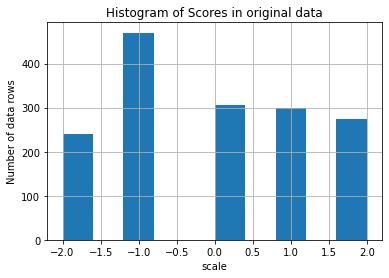

In [34]:
# plotting histogram of scores
dataset['scale'].hist()
plt.title("Histogram of Scores in original data")
plt.xlabel("scale")
plt.ylabel("Number of data rows")

In [35]:
# Check null values
dataset.isna().sum().to_frame(name='# of missing values')

,# of missing values
comment,0
scale,0


In [36]:
#Remove rows which are having null values
total_rows =  dataset.shape[0]
dataset.dropna(how='any',inplace=True)
remaining_rows= dataset.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 0

Percentage of data removed:0.0%
Percentage of data remaining:100.0%


In [37]:
#Remove duplicate rows
a =  dataset.shape[0]
dataset.drop_duplicates(inplace=True, subset=['comment','scale'])
b = dataset.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 3

Percentage of data removed: 0.19%
Percentage of data remaining: 99.81%


In [41]:
#Create target column using Score
df=dataset.replace({'scale' : { -2:0,-1:1,0:2,1:3,2:4 }})

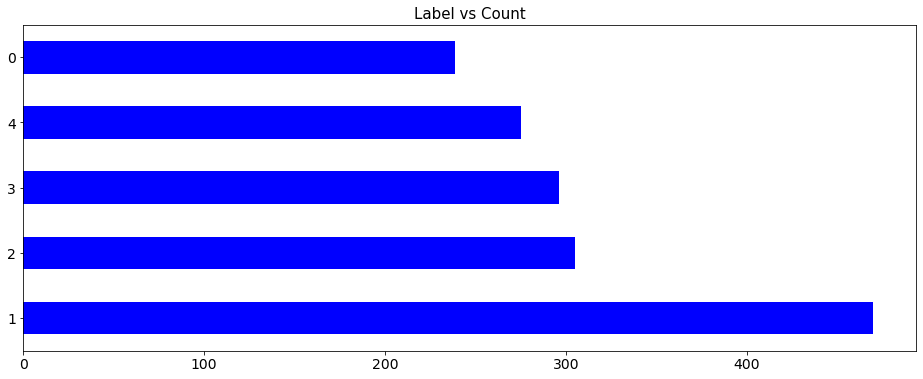

In [43]:
#Handling class imbalance
fig, ax = plt.subplots(figsize=(16, 6))

vc = df.scale.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()
    

In [52]:
vneg = df.loc[df.scale==0] .sample(220)
neg = df.loc[df.scale==1] .sample(300)
neu = df.loc[df.scale==2] .sample(300)
pos = df.loc[df.scale==3] .sample(250)
vpos = df.loc[df.scale==4] .sample(250)


df = pd.concat([vneg, neg, neu,pos,vpos])


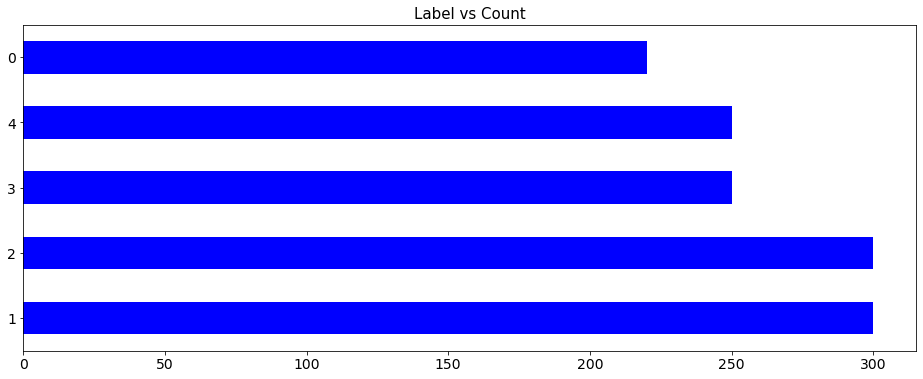

In [53]:
#Scale distribution (after)
fig, ax = plt.subplots(figsize=(16, 6))

vc = df.scale.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [55]:
#Data Pre-processing
#Stop words
# stopwords
total_stopwords = set(stopwords.words('slovak'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "nie" in word or 'č' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'tak', 'tu', 'ani', 'my', 'vám', 'kto', 'tomto', 'a', 'jej', 'môže', 'preto', 'budeš', 'ďalší', 'do', 'aj', 'podľa', 'váš', 'tiež', 'boli', 'mnou', 'pýta', 'tohoto', 'of', 'one', 'pre', 'prvé', 'bude', 'takže', 'predo', 'môcť', 'oni', 'práve', 'vy', 'za', 'bol', 'každí', 'vo', 'cez', 'iba', 'ho', 'si', 'z', 'bola', 'tomuto', 'po', 'môj', 'než', 'for', 'nám', 'budú', 'lebo', 'mna', 'naši', 'ďalšie', 'keď', 'asi', 'ďalšia', 'kde', 'svojím', 'and', 'byť', 'nech', 'zo', 'svojich', 'on', 'pred', 'na', 's', 'ich', 'svojími', 'ale', 'je', 'len', 'sa', 'prvá', 'každý', 'náš', 'by', 'tento', 'toto', 'to', 'že', 'ty', 'ma', 'prví', 'tú', 'sme', 'všetok', 'nad', 'nový', 'noví', 'od', 'potom', 'teda', 'týmto', 'bez', 'pokiaľ', 'túto', 'musieť', 'pri', 'však', 'má', 'ktorou', 'mne', 'alebo', 'bolo', 'ja', 'svoje', 'odo', 'the', 'vaše', 'každá', 'ako', 'jeho', 'te', 'tě', 'ona', 'tom', 'každé', 'sú', 'tieto', 'máte', 'tvojími', 'mať', 'viac', 'ktorá', 'iné', 'áno', 'v', 'budem', 'budeme', 'o', 'ku'

In [ ]:
#Remove unwanted words from comment
